In [4]:
import os
import time
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm


import librosa
from pydub import AudioSegment
from pydub.silence import split_on_silence


from sklearn.model_selection import GroupShuffleSplit, KFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler



import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dropout, LSTM
from keras.models import Model, Sequential
from keras.optimizers import SGD

import opensmile

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

In [4]:
#print("Current directory:", os.getcwd())
#print("Directory contents:", os.listdir('.'))

from src import lstm, LSTM2
from src.data_loader import DataLoader

In [5]:
def one_hot_encoder(y):
    enc = OneHotEncoder(sparse_output=False)  
    return enc.fit_transform(y.reshape(-1, 1)) 


def normalization(X):
    scaler = StandardScaler()
    X_shape = X.shape
    if len(X_shape) == 3:
        X_reshaped = X.reshape(-1, X.shape[-1])
        X_scaled = scaler.fit_transform(X_reshaped)
        X = X_scaled.reshape(X_shape[0], X_shape[1], X_shape[2])
        return X
    else:
        print("Debería ser dimenison 3")


In [2]:
speech_unprocessed_path = r'data/Audio_Speech_Actors_01-24/*/*.wav'
song_unprocessed_path = r'data/Audio_Song_Actors_01-24/*/*.wav'

speech_dataset_path = "data/speech_dataset.npy"
song_dataset_path = "data/song_dataset.npy"

In [ ]:
"""
class Dataloader():
    def __init__(self):
        pass
        # super(AudioDataloader, self).__init__(*args, **kwargs)
        # self.collate_fn = collate_fn

    def segment_audio(self, audio, num_parts):
        segment_length = len(audio) // num_parts
        segments = [audio[i * segment_length:(i + 1) * segment_length] for i in range(num_parts)]
        
        # Si el audio no se divide exactamente en partes iguales, añade el residuo al último segmento
        if len(audio) % num_parts != 0:
            segments[-1] = np.concatenate([segments[-1], audio[num_parts * segment_length:]])
        
        return segments


    def process_dataset(self, data_path, save_path, n_segments = 1):
        files = glob(data_path)

        smile = opensmile.Smile(
            feature_set=opensmile.FeatureSet.eGeMAPSv02,
            feature_level=opensmile.FeatureLevel.Functionals,
        )
        extracted_features = smile.process_files(files)

        x_ = extracted_features.values
        y_ = np.array([int(os.path.basename(path).split('-')[2]) for path in files])
        y_reshaped = y_[:, np.newaxis] 
        dataset = np.concatenate((x_, y_reshaped), axis=1)
        
        actors = np.array([int(os.path.dirname(path)[-2:]) for path in files])
        np.save(save_path, dataset)
        actors_save_path = f"data/{os.path.basename(save_path).split('_')[0]}_actors.npy"
        np.save(actors_save_path, actors)

        #np.savez(save_path, array1=dataset, array2=actors)
        return np.load(save_path), np.load(actors_save_path)
    
    def get_dataset(self, dataset_path_list):
        dataset = np.load(dataset_path_list[0])
        actors_path_list = f"{os.path.dirname(dataset_path_list[0])}/{os.path.basename(dataset_path_list[0]).split('_')[0]}_actors{os.path.splitext(dataset_path_list[0])[1]}"
        actors = np.load(actors_path_list)
        for i in range(1, len(dataset_path_list)):
            dataset = np.concatenate((dataset, np.load(dataset_path_list[i])))
            actors_path_list = f"{os.path.dirname(dataset_path_list[i])}/{os.path.basename(dataset_path_list[i]).split('_')[0]}_actors{os.path.splitext(dataset_path_list[i])[1]}"
            actors = np.concatenate((actors, np.load(actors_path_list)))
        x = dataset[:, :-1]
        y = dataset[:,-1]

        
        return x, y, actors

    def split_dataset(self, x, y, actors = [], n_splits =1):
        if len(actors) >0:
            gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
            train_idx, test_idx = next(gss.split(x, y, actors))
            X_train, X_test = x[train_idx], x[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            actors_train = actors[train_idx]
            actors_test = actors[test_idx]
       
        else:
            X_train, X_test, y_train, y_test = train_test_split(x, y, shuffle=42)
            actors_train = None
            actors_test = None
        return X_train, X_test, y_train, y_test, actors_train, actors_test

DL = Dataloader()
"""

In [ ]:
"""def calculate_energy(audio, frame_size, hop_length):
    energy = np.array([np.sum(np.abs(audio[i:i+frame_size]**2)) for i in range(0, len(audio), hop_length)])
    return energy

def trim_silence(audio, frame_size=1024, hop_length=512, energy_threshold=0.01):
    energy = calculate_energy(audio, frame_size, hop_length)
    frames = np.nonzero(energy > energy_threshold)[0]
    
    if len(frames) > 0:
        start = max(0, frames[0] * hop_length)
        end = min(len(audio), frames[-1] * hop_length + frame_size)
        return audio[start:end]
    else:
        return audio  # No recortar si no se encuentran frames con energía suficiente
"""


In [ ]:
## tendria qeu hacer el split de train y test antes para que siempre sea el mismo test
"""
class AudioProcessor:
    def segment_audio(self, audio, num_parts, frame_size=1024, hop_length=512, energy_threshold=0.01):
        # Recortar los silencios basados en la energía
        #print("")
        #print("audio largo", len(audio))
        trimmed_audio = trim_silence(audio, frame_size, hop_length, energy_threshold)
        #print("trimmed largo", len(trimmed_audio))
        print("Largo trimmed", len(trimmed_audio))
        if len(trimmed_audio) < 10000:
            plt.plot(audio)
            plt.show()
            print("Largo trimmed", len(trimmed_audio))
            plt.plot(trimmed_audio)
            plt.show()

        # Segmentar el audio recortado
        segment_length = len(trimmed_audio) // num_parts
        segments = []

        for i in range(num_parts):
            start = i * segment_length
            end = (i + 1) * segment_length
            segment = trimmed_audio[start:end]
            
            # Si el segmento es demasiado corto, rellenar con ceros
            if len(segment) < segment_length:
                segment = np.pad(segment, (0, segment_length - len(segment)), 'constant')
            
            segments.append(segment)
        
        return segments



    def segment_audio2(self, audio, num_parts, top_db=30):
        # Recortar los silencios
        #print("")
        #print("audio largo", len(audio))
        trimmed_audio, _ = librosa.effects.trim(audio, top_db=top_db)

        #print("trimmed largo", len(trimmed_audio))
        if len(trimmed_audio) == len(audio):
            plt.plot(audio)
            plt.show()
            print(audio)
            plt.plot(trimmed_audio)
            plt.show()
        segment_length = len(trimmed_audio) // num_parts
        segments = []

        for i in range(num_parts):
            start = i * segment_length
            end = (i + 1) * segment_length
            segment = trimmed_audio[start:end]
            #print("start", start)
            #print("end", end)
            
            # Si el segmento es demasiado corto, rellenar con ceros
            if len(segment) < segment_length:
                segment = np.pad(segment, (0, segment_length - len(segment)), 'constant')
            
            segments.append(segment)
        
        return segments


    def process_dataset(self, data_path, save_path, n_segments=1):

        files = glob(data_path)
        #files = [data_path]

        smile = opensmile.Smile(
            feature_set=opensmile.FeatureSet.eGeMAPSv02,
            feature_level=opensmile.FeatureLevel.Functionals,
        )

        features_list = []
        labels_list = []

        for file in files:
            # Cargar y segmentar el audio
            audio, sr = sf.read(file)
            print(file)
            segments = self.segment_audio2(audio, n_segments) ## CAMBIO sacar el 2

            for segment in segments:
                #print(len(segment))
                segment_file = 'temp_segment.wav'
                sf.write(segment_file, segment, sr)
                features = smile.process_file(segment_file)
                features_list.append(features.values.flatten())
                labels_list.append(int(os.path.basename(file).split('-')[2]))

        x_ = np.array(features_list)
        y_ = np.array(labels_list)
        
        y_reshaped = y_[:, np.newaxis]
        dataset = np.concatenate((x_, y_reshaped), axis=1)

        actors = np.array([int(os.path.dirname(path)[-2:]) for path in files])
        np.save(save_path, dataset)
        print('guardo el dataset en,', save_path)
        actors_save_path = define_actors_path(save_path)
        np.save(actors_save_path, actors)

        return np.load(save_path)

    def get_dataset(self, dataset_path_list):
        n_segments = int(os.path.basename(dataset_path_list[0])[0])
        dataset = np.load(dataset_path_list[0])
        actors_path = define_actors_path(dataset_path_list[0])
        print(actors_path)
        actors = np.load(actors_path)
        
        for i in range(1, len(dataset_path_list)):
            dataset = np.concatenate((dataset, np.load(dataset_path_list[i])))
            actors_path = actors_path = define_actors_path(dataset_path_list[i])
            actors = np.concatenate((actors, np.load(actors_path)))

        # Extraer características (x) y etiquetas (y)
        x = dataset[:, :-1]
        y = dataset[:, -1]
        # Realizar reshape de x
        num_samples = x.shape[0] // n_segments
        num_features = x.shape[1]
        x = x.reshape(num_samples, n_segments, num_features)
        
        # Realizar reshape de y
        y = y.reshape(num_samples, n_segments).mean(axis=1).astype(int)
        
        # Ajustar actores al nuevo número de muestras
        #actors_reshaped = actors.reshape(num_samples, n_segments).mean(axis=1).astype(int)

        print(x.shape)
        print(y.shape)
        print(actors.shape)
        return x, y, actors

    def split_dataset(self, x, y, test_size = 0.2, actors=[]):
        if len(actors) > 0:
            gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
            train_idx, test_idx = next(gss.split(x, y, actors))
            X_train, X_test = x[train_idx], x[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            actors_train = actors[train_idx]
            print("ACTORES", len(np.unique(actors_train)))
            actors_test = actors[test_idx]

            train_shuffle_idx = np.random.permutation(len(X_train))
            test_shuffle_idx = np.random.permutation(len(X_test))
            
            X_train, y_train, actors_train = X_train[train_shuffle_idx], y_train[train_shuffle_idx], actors_train[train_shuffle_idx]
            X_test, y_test, actors_test = X_test[test_shuffle_idx], y_test[test_shuffle_idx], actors_test[test_shuffle_idx]

        else:
            X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)
            actors_train = None
            actors_test = None

        return X_train, X_test, y_train, y_test, actors_train, actors_test
    
def define_actors_path(dataset_path):
    file_name = os.path.basename(dataset_path).split('_')
    file_name[-1] = file_name[-1].split('.')[0]
    actors_save_path = f"data/{file_name[0]}_{file_name[1]}_actors_{file_name[3]}.npy"
    return actors_save_path


AP = AudioProcessor()
"""


In [6]:
DL = DataLoader()



se inicializo


In [7]:
speech1_dataset_dev = "data/1part_Speech_dataset_dev.npy"
speech2_dataset_dev = "data/2part_Speech_dataset_dev.npy"
speech4_dataset_dev = "data/4part_Speech_dataset_dev.npy"
speech8_dataset_dev = "data/8part_Speech_dataset_dev.npy"

speech1_dataset_test = "data/1part_Speech_dataset_test.npy"
speech2_dataset_test = "data/2part_Speech_dataset_test.npy"
speech4_dataset_test = "data/4part_Speech_dataset_test.npy"
speech8_dataset_test = "data/8part_Speech_dataset_test.npy"

path_dev = r"data\Audio_Speech_Actors_01-24\*\*"
path_test = r"data/data_test/speech/*/*"


"data\Audio_Speech_Actors_01-24\Actor_09\03-01-04-01-01-01-09.wav"
r"data\Audio_Speech_Actors_01-24\Actor_09\03-01-02-01-02-01-09(1).wav"

'data\\Audio_Speech_Actors_01-24\\Actor_09\\03-01-02-01-02-01-09(1).wav'

In [ ]:
DL.process_dataset(path_dev, speech4_dataset_dev, 4)


data/4part_Speech_actors_dev.npy
X shape (1156, 4, 88)
y shape (1156,)
actors shape (1156,)
data/4part_Speech_actors_test.npy
X shape (300, 4, 88)
y shape (300,)
actors shape (300,)


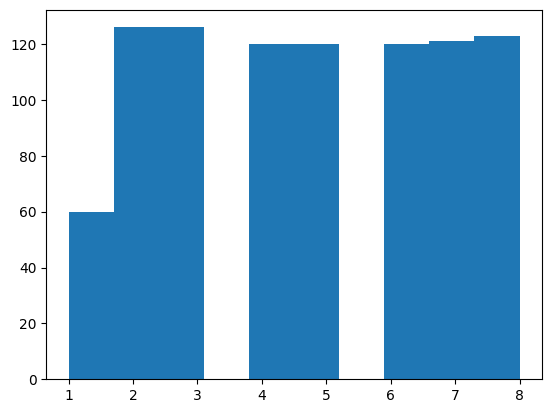

In [25]:
X_dev, y_dev, actors_dev = DL.get_dataset([speech4_dataset_dev])
X_train, X_valid, y_train, y_valid, actors_train, actors_valid = DL.split_dataset(X_dev, y_dev, test_size=0.2, actors=actors_dev)
X_test, y_test, actors_test = DL.get_dataset([speech4_dataset_test])

plt.hist(y_train)
plt.show()


X_train = normalization(X_train)
X_valid = normalization(X_valid)
X_test = normalization(X_test)

y_train_ohe  = one_hot_encoder(y_train)
y_valid_ohe = one_hot_encoder(y_valid)
y_test_ohe = one_hot_encoder(y_test)
y_dev_ohe = one_hot_encoder(y_dev)



## LSTM con keras

In [32]:

def cross_validate_rnn(X, y, groups, n_splits=5, epochs=10, batch_size=32):
    valid_loss = []
    gkf = GroupKFold(n_splits=n_splits)
    fold_no = 1
    for train_index, val_index in gkf.split(X, y, groups):
        print(f'Training fold {fold_no} ...')
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model = lstm.rnnLSTM(X_train, y_train)
        model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)

        val_loss, val_accuracy = model.evaluate(X_val, y_val)
        print(f'Fold {fold_no} - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        valid_loss.append(val_loss)
        fold_no += 1
    return np.mean(valid_loss)



Training fold 1 ...
Epoch 1/10
57/57 [==============================] - 5s 26ms/step - loss: 2.0983 - accuracy: 0.1264 - val_loss: 2.0606 - val_accuracy: 0.1260
Epoch 2/10
57/57 [==============================] - 1s 9ms/step - loss: 2.0707 - accuracy: 0.1440 - val_loss: 2.0423 - val_accuracy: 0.1585
Epoch 3/10
57/57 [==============================] - 1s 10ms/step - loss: 2.0473 - accuracy: 0.1626 - val_loss: 2.0399 - val_accuracy: 0.1504
Epoch 4/10
57/57 [==============================] - 1s 9ms/step - loss: 2.0528 - accuracy: 0.1440 - val_loss: 2.0310 - val_accuracy: 0.1545
Epoch 5/10
57/57 [==============================] - 1s 10ms/step - loss: 2.0489 - accuracy: 0.1341 - val_loss: 2.0259 - val_accuracy: 0.2154
Epoch 6/10
57/57 [==============================] - 1s 9ms/step - loss: 2.0402 - accuracy: 0.1538 - val_loss: 2.0256 - val_accuracy: 0.1951
Epoch 7/10
57/57 [==============================] - 1s 10ms/step - loss: 2.0335 - accuracy: 0.1813 - val_loss: 2.0230 - val_accuracy: 0.1

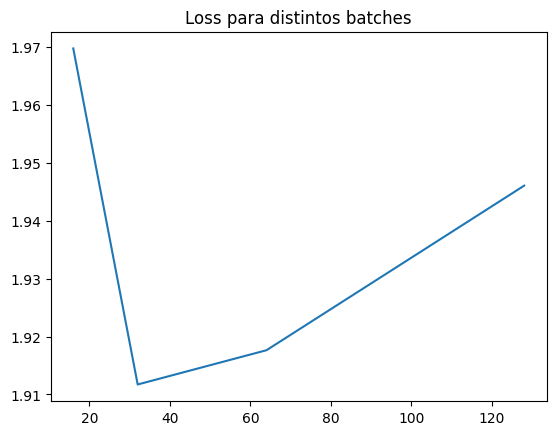

In [34]:
batches_size = [16, 32, 64, 128]
valid_loss = []
for batch_s in batches_size:
    loss = cross_validate_rnn(X_dev, y_dev_ohe, actors_dev, batch_size=batch_s)
    valid_loss.append(loss)
plt.plot(batches_size, valid_loss)
plt.title("Loss para distintos batches")
plt.show()

In [15]:
print("train")


y_train_ohe  = one_hot_encoder(y_train)
y_valid_ohe = one_hot_encoder(y_valid)
y_test_ohe = one_hot_encoder(y_test)

R = lstm.rnnLSTM(X_train, y_train_ohe)
R.train(X_train, y_train_ohe, X_valid, y_valid_ohe, epochs=10, batch_size=32)

train
Training fold 1 ...
Epoch 1/10
23/23 [==============================] - 4s 40ms/step - loss: 2.0208 - accuracy: 0.2008 - val_loss: 1.9573 - val_accuracy: 0.2717
Epoch 2/10
23/23 [==============================] - 0s 11ms/step - loss: 1.8434 - accuracy: 0.2650 - val_loss: 1.8116 - val_accuracy: 0.2663
Epoch 3/10
23/23 [==============================] - 0s 11ms/step - loss: 1.6929 - accuracy: 0.3484 - val_loss: 1.6876 - val_accuracy: 0.3261
Epoch 4/10
23/23 [==============================] - 0s 12ms/step - loss: 1.5510 - accuracy: 0.4153 - val_loss: 1.5621 - val_accuracy: 0.3641
Epoch 5/10
23/23 [==============================] - 0s 11ms/step - loss: 1.4342 - accuracy: 0.4454 - val_loss: 1.4969 - val_accuracy: 0.4022
Epoch 6/10
23/23 [==============================] - 0s 11ms/step - loss: 1.3631 - accuracy: 0.4891 - val_loss: 1.4251 - val_accuracy: 0.4348
Epoch 7/10
23/23 [==============================] - 0s 10ms/step - loss: 1.2315 - accuracy: 0.5533 - val_loss: 1.4314 - val_accu

1.2612184047698975

In [ ]:
print("test")
test_loss, test_accuracy = R.evaluate(X_test, y_test_ohe)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

## LSTM con pythorch

In [10]:
"""input_size = 3       # Número de características de entrada
hidden_size = 64     # Número de características en el estado oculto
num_classes = 8      # Número de clases de salida
num_layers = 1       # Número de capas de la LSTM
learning_rate = 0.001
batch_size = 32
num_epochs = 50

X_train_batch, y_train_batch = DL.create_batches(X_train, y_train, batch_size)
lstm_ = LSTM2.LSTMClassifier(input_size, hidden_size, num_classes, num_layers)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_.parameters(), lr=learning_rate)
lstm_.train_model(X_train_batch, y_train_batch, criterion, optimizer, num_epochs=20)
"""

'input_size = 3       # Número de características de entrada\nhidden_size = 64     # Número de características en el estado oculto\nnum_classes = 8      # Número de clases de salida\nnum_layers = 1       # Número de capas de la LSTM\nlearning_rate = 0.001\nbatch_size = 32\nnum_epochs = 50\n\nX_train_batch, y_train_batch = DL.create_batches(X_train, y_train, batch_size)\nlstm_ = LSTM2.LSTMClassifier(input_size, hidden_size, num_classes, num_layers)\n\ncriterion = nn.CrossEntropyLoss()\noptimizer = optim.Adam(lstm_.parameters(), lr=learning_rate)\nlstm_.train_model(X_train_batch, y_train_batch, criterion, optimizer, num_epochs=20)\n'

In [ ]:
"""x, y, actors = AP.get_dataset([speech8_dataset])
X_train, X_test, y_train, y_test, actors_train, actors_test = AP.split_dataset(x, y, test_size=0.2, actors=actors)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(actors_train.shape)
print(actors_test.shape)

X_train, X_valid, y_train, y_valid, actors_train, actors_valid = AP.split_dataset(X_train, y_train, test_size=0.2, actors=actors_train)
print("train:", X_train.shape)
print("valid:", X_valid.shape)

plt.hist(y_train)
plt.show()

y_train = one_hot_encoder(y_train)
y_valid = one_hot_encoder(y_valid)

scaler = StandardScaler()
shape_train = X_train.shape
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_train = X_train_scaled.reshape(shape_train[0], shape_train[1], shape_train[2])

shape_valid = X_valid.shape
X_val_reshaped = X_valid.reshape(-1, X_valid.shape[-1])
X_val_scaled = scaler.transform(X_val_reshaped)
X_val = X_val_scaled.reshape(shape_valid[0], shape_valid[1], shape_valid[2])


print(X_train.shape)


model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_valid, y_valid))"""

In [ ]:
"""y_test = one_hot_encoder(y_test)

shape = X_test.shape
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled = scaler.transform(X_test_reshaped)
X_test = X_test_scaled.reshape(shape[0], shape[1], shape[2])

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
"""

In [ ]:
y_pred = model.predict(X_test)

# Convertir las predicciones de one-hot encoding a etiquetas
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

print(y_pred_labels)
print(y_test_labels)

In [ ]:
#NO CORRER, USAR Dataloader.get_dataset() y Dataloader.split_dataset()
DL.process_dataset(speech_unprocessed_path, speech_dataset_path)
DL.process_dataset(song_unprocessed_path, song_dataset_path)

In [ ]:
# A partir de aca el TEST no se toca mas.
# Hay que hacer otra division del dev set para formar el train set y valid set.

x_speech, y_speech, actors_speech = DL.get_dataset([speech_dataset_path])
x_song, y_song, actors_song = DL.get_dataset([song_dataset_path])
x_both, y_both, actors_both = DL.get_dataset([speech_dataset_path, song_dataset_path])

# Estos son los datasets DIVIDIDOS POR ACTORES para el dev set y test set.
X_speech_byactors_dev, X_speech_byactors_test, y_speech_byactors_dev, y_speech_byactors_test, actors_speech_dev, actors_speech_test = DL.split_dataset(x_speech, y_speech, actors_speech)
X_song_byactors_dev, X_song_byactors_test, y_song_byactors_dev, y_song_byactors_test, actors_song_dev, actors_song_test = DL.split_dataset(x_song, y_song, actors_song)
X_both_byactors_dev, X_both_byactors_test, y_both_byactors_dev, y_both_byactors_test, actors_both_dev, actors_both_test = DL.split_dataset(x_both, y_both, actors_both)

# Estos son los datasets NO divididos por actores para el dev set y test set.
X_speech_dev, X_speech_test, y_speech_dev, y_speech_test, _ , _ = DL.split_dataset(x_speech, y_speech)
X_song_dev, X_song_test, y_song_dev, y_song_test, _ , _ = DL.split_dataset(x_song, y_song)
X_both_dev, X_both_test, y_both_dev, y_both_test, _ , _ = DL.split_dataset(x_both, y_both)


In [ ]:
# DIVISION ENTRE TRAIN SET Y VALIDATION SET

X_speech_byactors_train, X_speech_byactors_valid, y_speech_byactors_train, y_speech_byactors_valid, actors_speech_train, actors_speech_valid = DL.split_dataset(X_speech_byactors_dev, y_speech_byactors_dev, actors_speech_dev)
X_song_byactors_train, X_song_byactors_valid, y_song_byactors_train, y_song_byactors_valid, actors_song_train, actors_song_valid = DL.split_dataset(X_song_byactors_dev, y_song_byactors_dev, actors_song_dev)
X_both_byactors_train, X_both_byactors_valid, y_both_byactors_train, y_both_byactors_valid, actors_both_train, actors_both_valid = DL.split_dataset(X_both_byactors_dev, y_both_byactors_dev, actors_both_dev)

X_speech_train, X_speech_valid, y_speech_train, y_speech_valid, _ , _ = DL.split_dataset(X_speech_dev, y_speech_dev)
X_song_train, X_song_valid, y_song_train, y_song_valid, _ , _ = DL.split_dataset(X_song_dev, y_song_dev)
X_both_train, X_both_valid, y_both_train, y_both_valid, _ , _ = DL.split_dataset(X_both_dev, y_both_dev)


### habria que hacer una funcion que devuelva especificamente el train, valid del dataset que queremos. Ahora lo hice asi para ya tenerlos todos creados y poder probarlos.


In [ ]:

x_train_norm = normalization(X_speech_byactors_train, np.mean(X_speech_byactors_train, axis=0), np.std(X_speech_byactors_train, axis=0))
x_valid_norm = normalization(X_speech_byactors_valid, np.mean(X_speech_byactors_train, axis=0), np.std(X_speech_byactors_train, axis=0))
print(x_train_norm.shape)
print(x_valid_norm.shape)

In [ ]:
classes_speech, classes_count_speech = np.unique(y_speech, return_counts=True)
classes_song, classes_count_song = np.unique(y_song, return_counts=True)

fig, axs = plt.subplots(1, 2, figsize=(8, 4)) 

axs[0].bar(classes_speech, classes_count_speech)
axs[0].set_title('Speech dataset')
axs[0].set_xlabel('Clase')
axs[0].set_ylabel('Cantidad de muestras')
axs[0].set_xticks(classes_speech) 

axs[1].bar(classes_song, classes_count_song)
axs[1].set_title('Song dataset')
axs[1].set_xlabel('Clase')
axs[1].set_ylabel('Cantidad de muestras')
axs[1].set_xticks(classes_song)

plt.tight_layout()
plt.show()

#NOTE: There is no strong intensity for the 'neutral' emotion.

In [ ]:
print(np.unique(y_speech))
print(np.unique(y_song))

# y_speech = y_speech.astype(int)
# y_song = y_song.astype(int)

In [ ]:
scaler_speech = StandardScaler()
x_speech_scaled = scaler_speech.fit_transform(x_speech)

scaler_song = StandardScaler()
x_song_scaled = scaler_song.fit_transform(x_song)

pca_speech = PCA(n_components=2)
pca_speech_result = pca_speech.fit_transform(x_speech_scaled)
pca_speech_df = pd.DataFrame(data=pca_speech_result, columns=['PCA1', 'PCA2'])
pca_speech_df['Label'] = y_speech

pca_song = PCA(n_components=2)
pca_song_result = pca_song.fit_transform(x_song_scaled)
pca_song_df = pd.DataFrame(data=pca_song_result, columns=['PCA1', 'PCA2'])
pca_song_df['Label'] = y_song

sns.scatterplot(x='PCA1', y='PCA2', hue='Label', data=pca_speech_df, palette='viridis')
plt.title('PCA of Speech Features')
plt.legend(title='Emotion')
plt.show()

sns.scatterplot(x='PCA1', y='PCA2', hue='Label', data=pca_song_df, palette='viridis')
plt.title('PCA of Song Features')
plt.legend(title='Emotion')
plt.show()

tsne_speech = TSNE(n_components=2, random_state=42)
tsne_speech_result = tsne_speech.fit_transform(x_speech_scaled)
tsne_speech_df = pd.DataFrame(data=tsne_speech_result, columns=['TSNE1', 'TSNE2'])
tsne_speech_df['Label'] = y_speech

tsne_song = TSNE(n_components=2, random_state=42)
tsne_song_result = tsne_song.fit_transform(x_song_scaled)
tsne_song_df = pd.DataFrame(data=tsne_song_result, columns=['TSNE1', 'TSNE2'])
tsne_song_df['Label'] = y_song

sns.scatterplot(x='TSNE1', y='TSNE2', hue='Label', data=tsne_speech_df, palette='viridis')
plt.title('t-SNE of Speech Features')
plt.legend(title='Emotion')
plt.show()

sns.scatterplot(x='TSNE1', y='TSNE2', hue='Label', data=tsne_song_df, palette='viridis')
plt.title('t-SNE of Song Features')
plt.legend(title='Emotion')
plt.show()


## Filename identifiers 

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

## Random Forest

In [ ]:
#X_both_train, X_both_test, y_both_train, y_both_test

num_trees = range(150, 200)
max_depth = range(3, 9, 2)
tree_model_accuracy = []
opt_md = 0
opt_n = 0
for md in range(len(max_depth)):
    for n in range(len(num_trees)):
        random_forest = RandomForestClassifier(n_estimators=num_trees[n], max_depth=max_depth[md],random_state= 32)
        random_forest.fit(X_speech_train, y_speech_train)
        y_predict = random_forest.predict(X_speech_test)
        acc = accuracy_score(y_speech_test, y_predict)
        tree_model_accuracy.append(acc)
        if np.max(tree_model_accuracy) == acc:
            opt_md = md
            opt_n = n




In [ ]:
print(f"opt md: {max_depth[opt_md]}, opt n: {num_trees[opt_n]}")
print(f"Max accuracy: {np.max(tree_model_accuracy)}")
plt.plot(range(len(tree_model_accuracy)), tree_model_accuracy)
plt.title("Accuracy")
plt.show()

In [ ]:
random_forest = RandomForestClassifier( random_state= 32)
random_forest.fit(x_train, y_train)
y_predict = random_forest.predict(x_test)
acc = accuracy_score(y_test, y_predict)
print(f" trees --> Accuracy {acc}")

conf_matrix = confusion_matrix(y_test, y_predict)
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_predict))


In [ ]:
class MLPAutoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(MLPAutoencoder, self).__init__()
        #self.flatten = nn.Flatten()
        self.encoder = nn.Linear(88, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, 88)
        #self.unflatten = torch.nn.Unflatten(1, 88)

    def forward(self, x):
        #x = self.flatten(x)
        out = F.relu(self.encoder(x))
        out = torch.sigmoid(self.decoder(out))
        return out
    
    def get_embedding(self, x):
        #x = self.flatten(x)
        return F.relu(self.encoder(x))
d = torch.from_numpy(x_train)
print(d.shape)
print(nn.Flatten(d))
print(d[0].shape)
print(d)
print(d.dtype)

In [ ]:
model = MLPAutoencoder(33).double()
pred = model(d)


In [ ]:
LR = 0.1
device = "cpu"
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

n_epochs = 20
model.to(device)
t_losses, v_losses = [], []
x_train_tensor = torch.from_numpy(x_train_norm)
x_test_tensor = torch.from_numpy(x_test_norm)

for epoch in tqdm(range(1, n_epochs+1)):
    # Training
    train_loss = 0.0
    for (X, y) in zip(x_train_tensor, y_train):
        X = torch.squeeze(X).to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, X)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
            
    # Eval        
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for (X, y) in zip(x_test_tensor, y_test):
            X = torch.squeeze(X).to(device)
            outputs = model(X)
            loss = criterion(outputs, X)
            test_loss += loss.item()        
            
    train_loss = train_loss/len(x_train)
    test_loss = test_loss/len(x_test)
    t_losses.append(train_loss)
    v_losses.append(test_loss)
    
plt.figure(figsize=(10,3))
plt.plot(np.arange(1,len(t_losses)+1), t_losses, label='Train loss')
plt.plot(np.arange(1,len(v_losses)+1),v_losses, label='Validation loss')
plt.xticks(np.arange(1,len(t_losses)+1))
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Redes neuronales

## CNN

In [32]:
import librosa
import librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob

emotion_labels = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def extract_spectrogram(audio_path, sr=22050, n_mels=224, fmax=8000):
    y, sr = librosa.load(audio_path, sr=sr)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return log_spectrogram

def save_spectrogram(spectrogram, save_path):
    plt.figure(figsize=(5, 5))
    librosa.display.specshow(spectrogram, sr=22050, x_axis='time', y_axis='mel', fmax=8000)
    plt.axis('off')
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

def process_files(files, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    for audio_path in files:
        filename = os.path.basename(audio_path)
        emotion_code = filename.split('-')[2] 
        emotion = emotion_labels.get(emotion_code, 'unknown')
        
        class_dir = os.path.join(output_path, emotion)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)
        
        spectrogram = extract_spectrogram(audio_path)
        save_path = os.path.join(class_dir, filename.replace('.wav', '.png'))
        save_spectrogram(spectrogram, save_path)

In [ ]:
import librosa
import librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 28 * 28, 2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.fc3 = nn.Linear(2048, 8)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, 32 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)


emotion_labels = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def extract_spectrogram(audio_path, sr=22050, n_mels=224, fmax=8000):
    y, sr = librosa.load(audio_path, sr=sr)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return log_spectrogram

def save_spectrogram(spectrogram, save_path):
    plt.figure(figsize=(5, 5))
    librosa.display.specshow(spectrogram, sr=22050, x_axis='time', y_axis='mel', fmax=8000)
    plt.axis('off')
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

def process_files(files, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    for audio_path in files:
        filename = os.path.basename(audio_path)
        emotion_code = filename.split('-')[2] 
        emotion = emotion_labels.get(emotion_code, 'unknown')
        
        class_dir = os.path.join(output_path, emotion)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)
        
        spectrogram = extract_spectrogram(audio_path)
        save_path = os.path.join(class_dir, filename.replace('.wav', '.png'))
        save_spectrogram(spectrogram, save_path)

dev_path = "data/data_dev/speech/*/*.wav"
test_path = "data/data_test/speech/*/*.wav"

files = glob(dev_path)
output_path = "data/spectrograms/speech"
process_files(files, output_path)
batch_size = 32
learning_rate = 0.001
momentum = 0.8
epochs = 20

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root=output_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model, optimizer, and loss function
model = CNN()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()

# Training the model
for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

print("Finished Training")

# Testing the model
test_files = glob(test_path)
test_output_path = "data/spectrograms_test/speech"
process_files(test_files, test_output_path)

test_dataset = datasets.ImageFolder(root=test_output_path, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy of the network on the test images: {accuracy:.2f}%")

# Predicting probabilities for the 8 emotions
with torch.no_grad():
    for inputs, _ in test_dataloader:
        outputs = model(inputs)
        probabilities = F.softmax(outputs, dim=1)
        print(probabilities.numpy())


In [34]:
dev_path = "data/data_dev/speech/*/*.wav"
test_path = "data/data_test/speech/*/*.wav"

files = glob(dev_path)
output_path = "data/spectrograms/speech"
process_files(files, output_path)

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 28 * 28, 2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.fc3 = nn.Linear(2048, 8)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, 32 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)

batch_size = 32
learning_rate = 0.001
momentum = 0.8
epochs = 20

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root=output_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# model = CNN()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, momentum=momentum)

# for epoch in range(epochs):
#     running_loss = 0.0
#     for i, data in enumerate(dataloader, 0):
#         inputs, labels = data
        
#         optimizer.zero_grad()
        
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
#         if i % 10 == 9:  
#             print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 10:.3f}")
#             running_loss = 0.0

model = CNN()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99: 
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

print("Finished Training")


[1, 10] loss: 2.133
[1, 20] loss: 2.133
[1, 30] loss: 2.137
[2, 10] loss: 2.121
[2, 20] loss: 2.140
[2, 30] loss: 2.149
[3, 10] loss: 2.130
[3, 20] loss: 2.137
[3, 30] loss: 2.137
[4, 10] loss: 2.137
[4, 20] loss: 2.149
[4, 30] loss: 2.143
[5, 10] loss: 2.130
[5, 20] loss: 2.162
[5, 30] loss: 2.118
[6, 10] loss: 2.143
[6, 20] loss: 2.105
[6, 30] loss: 2.155
[7, 10] loss: 2.149
[7, 20] loss: 2.118
[7, 30] loss: 2.140
[8, 10] loss: 2.130
[8, 20] loss: 2.127
[8, 30] loss: 2.152
[9, 10] loss: 2.143
[9, 20] loss: 2.137
[9, 30] loss: 2.146
[10, 10] loss: 2.140
[10, 20] loss: 2.152
[10, 30] loss: 2.105
[11, 10] loss: 2.115
[11, 20] loss: 2.149
[11, 30] loss: 2.130
[12, 10] loss: 2.130
[12, 20] loss: 2.165
[12, 30] loss: 2.118
[13, 10] loss: 2.137
[13, 20] loss: 2.143
[13, 30] loss: 2.140
[14, 10] loss: 2.155
[14, 20] loss: 2.124
[14, 30] loss: 2.127
[15, 10] loss: 2.121
[15, 20] loss: 2.137
[15, 30] loss: 2.133
[16, 10] loss: 2.121
[16, 20] loss: 2.112
[16, 30] loss: 2.152
[17, 10] loss: 2.14

In [ ]:
# torch.save(model.state_dict(), 'emotion_net.pth')

# model.load_state_dict(torch.load('emotion_net.pth'))
# model.eval()

# test_dataset = datasets.ImageFolder(root="pathdeltest", transform=transform)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# correct = 0
# total = 0
# with torch.no_grad():
#     for data in test_dataloader:
#         images, labels = data
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f'Accuracy of the network on the test images: {100 * correct / total}%')


In [ ]:
# class CNN_X(Model):
#     def __init__(self):
#         super(CNN_X, self).__init__()
#         self.conv1 = Conv2D(8, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 1))
#         self.avgpool1 = AveragePooling2D(pool_size=(2, 2))
#         self.conv2 = Conv2D(16, kernel_size=(3, 3), activation='relu')
#         self.avgpool2 = AveragePooling2D(pool_size=(2, 2))
#         self.conv3 = Conv2D(32, kernel_size=(3, 3), activation='relu')
#         self.avgpool3 = AveragePooling2D(pool_size=(2, 2))
#         self.flatten = Flatten()
#         self.fc1 = Dense(2048, activation='relu')
#         self.fc2 = Dense(2048, activation='relu')
#         self.fc3 = Dense(8, activation='softmax')

#     def call(self, inputs):
#         x = self.conv1(inputs)
#         x = self.avgpool1(x)
#         x = self.conv2(x)
#         x = self.avgpool2(x)
#         x = self.conv3(x)
#         x = self.avgpool3(x)
#         x = self.flatten(x)
#         x = self.fc1(x)
#         x = self.fc2(x)
#         return self.fc3(x)